Only considers relationship between oxygen and salinity when salinity >26


## Oxygen, DIC, TA linear relationships 
#### obtained from Debby's observational GRL dataset, JdF region

[O2 umol/kg] = -49.54 * [salinity psu] + 1763.29

[DIC umol/kg] = 68.98 * [salinity psu]  -100.14

[TA umol/kg] = 46.99 * [salinity psu]  + 666.62

In [54]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [55]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import cmocean
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline


In [56]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmask = mesh.variables['tmask'][0, :, :, :]
tmask = np.abs(tmask-1)
mesh.close()

#

In [57]:
sal = ds2.variables['sn']
sal_masked = np.ma.masked_array(sal, mask=tmask)
sal1 = sal_masked[0,0,:,:]
temp = ds2.variables['tn']
temp_masked = np.ma.masked_array(temp, mask=tmask)

temp1 = temp_masked[0,0,:,:]
temp_all = temp_masked[:,:,:,:]
surfmask = np.zeros_like(temp1)
deepmask = np.zeros_like(temp_all)
surfmask[temp1>0] = 4
deepmask[temp_all>0] =4

for y in range(0,898):
    for x in range(0,398):
        q = temp1[y,x]
        q = np.uint64(q)
        
        if  (x <200) & (y>220) & (y<500) & (q >0) :
            deepmask[:,:,y,x] = 1
        if  (y >= 550) & (q > 0):
            deepmask[:,:,y,x] = 2
        if (x> 150) & (y>310) & (y<550) & (q>0):
            deepmask[:,:,y,x] = 3

deepmask[temp_all==0] = 0

In [58]:
infil = loadtxt('../DATASETS/grl2016_edit2.txt')

In [59]:
crid= infil[:,0]
ln = infil[:,2]
stn = infil[:,3]
lat = infil[:,6]
lon = infil[:,7]
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
ox = infil[:,11]*44.6596
ox_qf = infil[:,12]
dic = infil[:,13]
alk = infil[:,15]
dic_qf = infil[:,14]
alk_qf = infil[:,16]
no3 = infil[:,17]
no3_qf = infil[:,18]
si = infil[:,19]
si_qf = infil[:, 20]
po4 = infil[:,21]
po4_qf = infil[:, 22]



In [60]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')

nav_lon = mesh.variables['nav_lon'][:]
nav_lat = mesh.variables['nav_lat'][:]
bathy = mesh.variables['Bathymetry'][:]

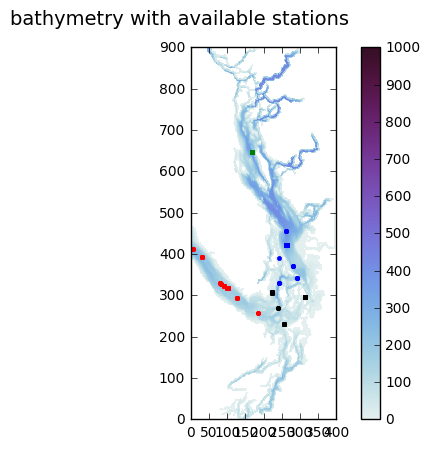

In [61]:
tag = infil[:,0]
fig, ax = plt.subplots(1, 1, figsize=(16*.4, 12*.4))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,860):
    j, i = geo_tools.find_closest_model_point(lon[w],lat[w],nav_lon,nav_lat)

    #JdF
    if  (i <200) & (j>220) & (j<500)  :
        tag[w] = 1
        ax.plot(i,j,'r.')
    #northern Strait
    if  (j >= 550) :
        tag[w] = 2
        ax.plot(i,j,'g.')
    # southern Strait    
    if (i> 150) & (j>310) & (j<550) :
        tag[w] = 3
        ax.plot(i,j,'b.')
        #puget
    if(i>=200) & (j<= 310):
        tag[w] = 4
        ax.plot(i,j,'k.')

    #ax.plot(i,j,'r.')
fig.colorbar(mesh)
plt.suptitle('bathymetry with available stations',fontsize=14)



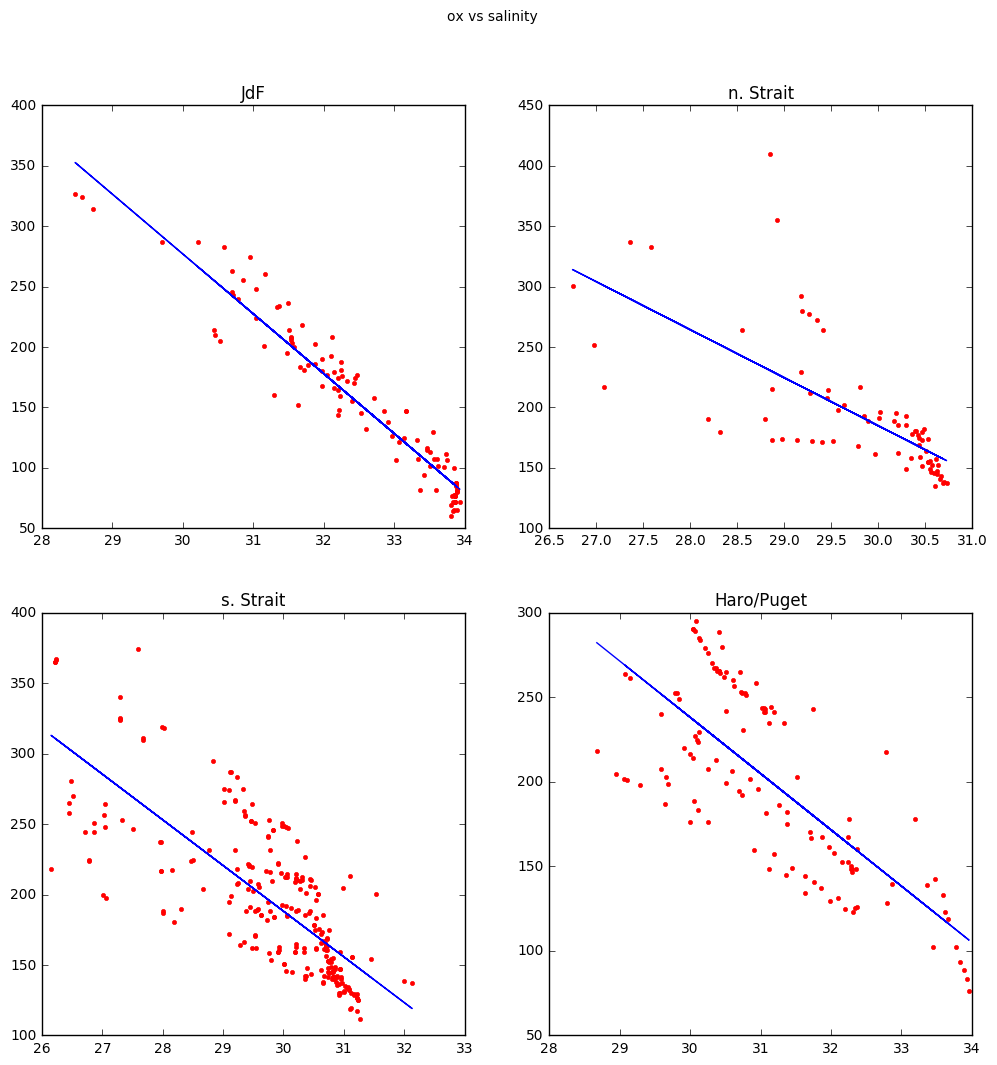

slopes:
[-49.54249586532451, -39.72957904678526, -32.42775473025329, -33.28969241709881]
intercepts:
[1763.2861180089592, 1376.8289629570922, 1161.0063795350468, 1236.8556606103382]
ox at 26
[475.1812255105219, 343.85990774067545, 317.88475654846127, 371.3236577657691]


In [62]:
from scipy import stats 
slopes_ox = [0,0,0,0]
ints_ox = [0,0,0,0]
oxs_at_26 = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    ox_toplot = ox[idx]
    #print(ox_toplot)
    idx_n = np.where(np.isfinite(ox_toplot) & np.greater_equal(S_toplot,26))
    #print(idx_n)
    S_nn = S_toplot[idx_n]
    ox_nn = ox_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_nn,ox_nn)
    line = slope*S_nn+intercept
    oxs_at_26[i-1] = slope*26+intercept
    slopes_ox[i-1] = slope
    ints_ox[i-1] = intercept
    ax.plot(S_nn,ox_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('ox vs salinity')
plt.show()

print('slopes:')
print(slopes_ox)
print('intercepts:')
print(ints_ox)
print('ox at 26')
print(oxs_at_26)

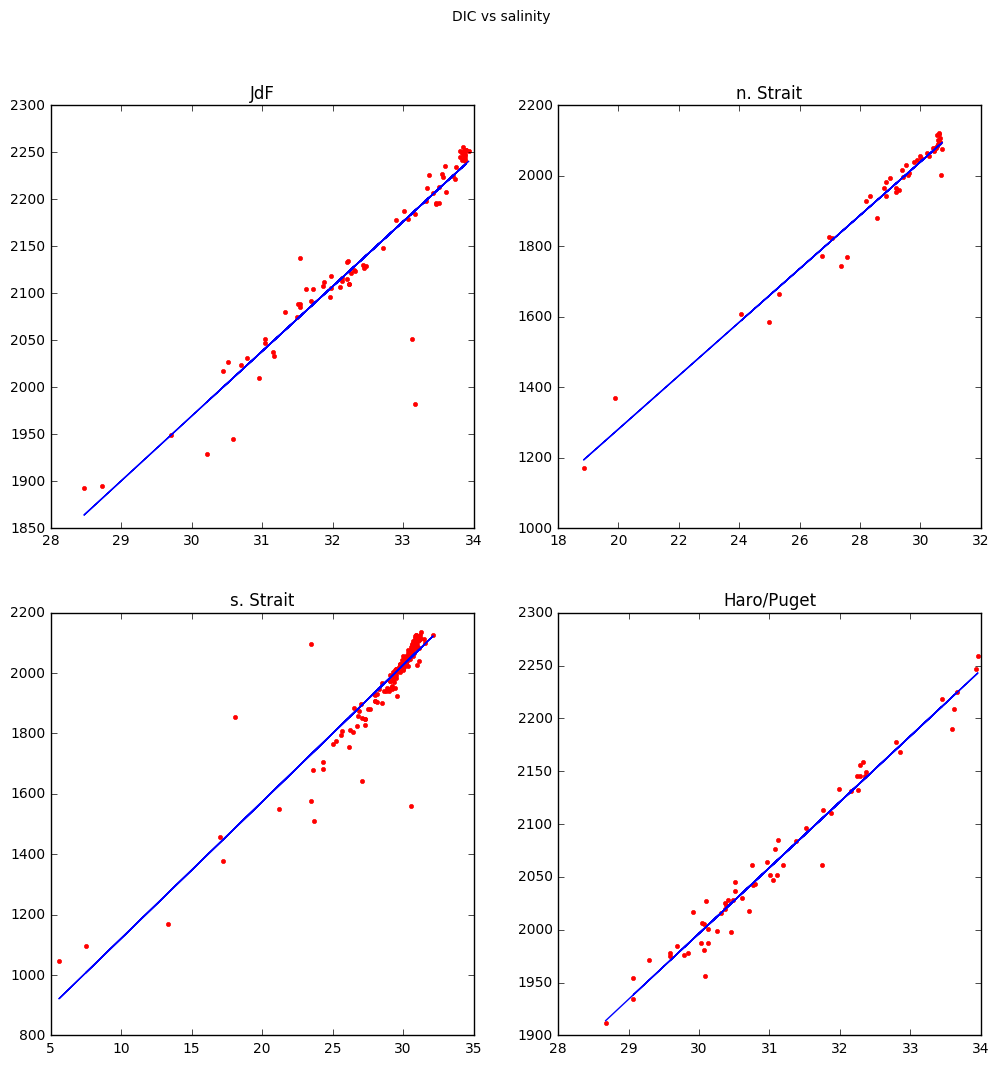

slopes:
[68.98450659182463, 75.85020217881677, 45.248982910520944, 62.27586828053622]
intercepts:
[-100.13978357455835, -235.7274253838657, 669.0670004789927, 128.20407948614115]


In [63]:
from scipy import stats 
slopes_DIC = [0,0,0,0]
ints_DIC = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    DIC_toplot = dic[idx]
    idx_n = np.where(np.isfinite(DIC_toplot))
    S_nn = S_toplot[idx_n]
    DIC_nn = DIC_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_nn,DIC_nn)
    line = slope*S_nn+intercept
    slopes_DIC[i-1] = slope
    ints_DIC[i-1] = intercept
    ax.plot(S_nn,DIC_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('DIC vs salinity')
plt.show()

print('slopes:')
print(slopes_DIC)
print('intercepts:')
print(ints_DIC)


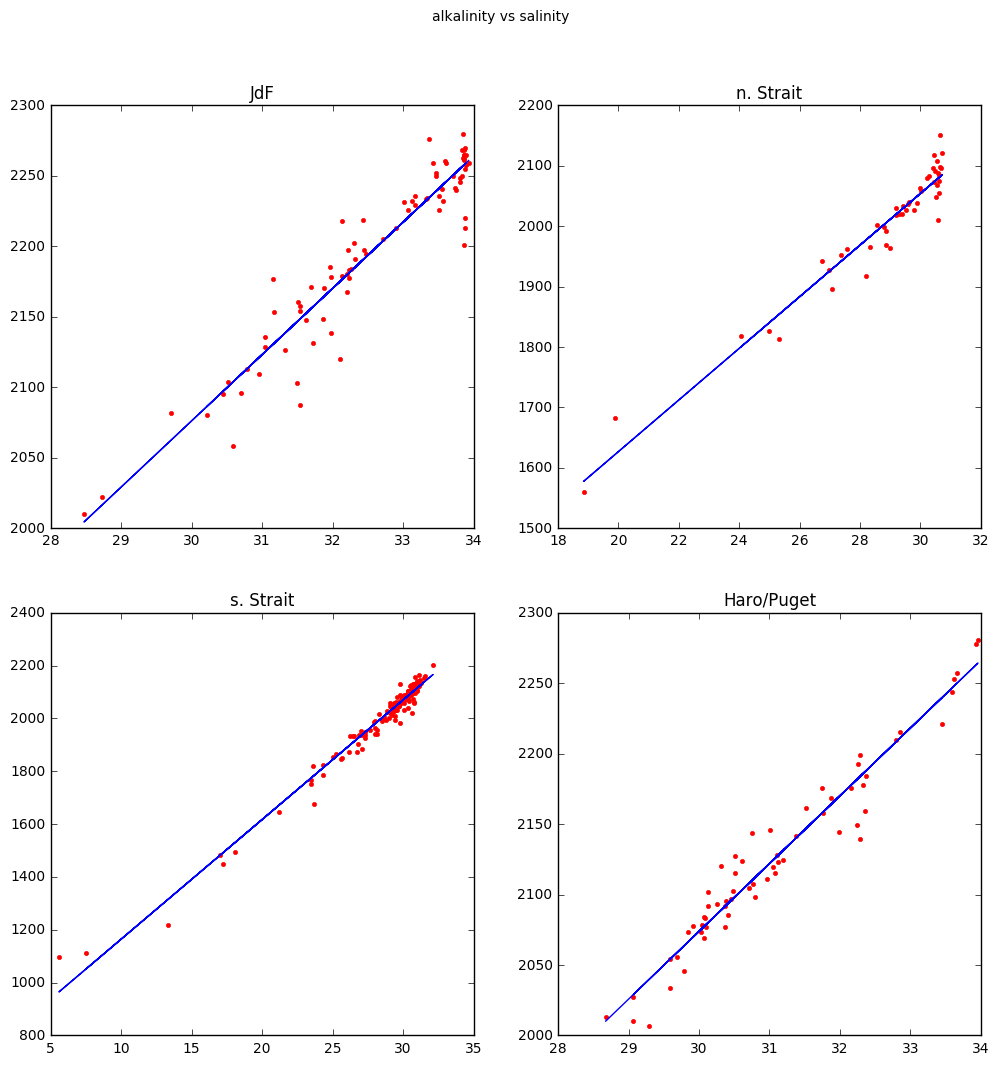

slopes:
[46.987083509452965, 42.738245289052664, 45.25510677271421, 48.09971832088455]
intercepts:
[666.6180299218545, 772.0719514299533, 712.254477007345, 630.8482167314171]


In [64]:
from scipy import stats
slopes_alk = [0,0,0,0]
ints_alk = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    alk_toplot = alk[idx]
    idx_n = np.where(np.isfinite(alk_toplot))
    S_nn = S_toplot[idx_n]
    alk_nn = alk_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(S_nn,alk_nn)
    line = slope*S_nn+intercept
    slopes_alk[i-1] = slope
    ints_alk[i-1] = intercept
    ax.plot(S_nn,alk_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('alkalinity vs salinity')
plt.show()

print('slopes:')
print(slopes_alk)
print('intercepts:')
print(ints_alk)